# VBF Tau Tau Jet Jet production code

### Install external packages needed

In [1]:
pip install uproot 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install vector 

Note: you may need to restart the kernel to use updated packages.


### Imports external packages needed

In [4]:
import uproot 
import vector 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import awkward as ak 

### Define all functions used in the filtering, selection, calculating, and plotting: 

In [84]:
file_paths = ['vbf_tau_batch_output', 'vbf_tau_batch_run_2_output', 'vbf_tau_batch_run3_output']
    
    
def data_extract(rootfilename):

    # Opens the .root file and extract the data

    tree = uproot.open(rootfilename+'.root:Delphes')

    events = tree.arrays(['Event.Weight','Electron_size', 'Electron.PT', 'Electron.Eta', 'Electron.Phi',
                              'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                          'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.TauTag', 'Jet.Mass', 'Jet.Flavor', 'Jet.BTag', 
                         'MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
    
    return events


def lepton_and_lepton(event, selection, lepton):
    #Selects events with two electrons and at least two jets, that can change the jet filters selection = 0 filter 
    #for no b jets and 2 or 3 light, 
    # selection = 1 is no be jets, selection = 2 doesnt mask based on b tagging 
    
    #creates four vectors of all detected particles in all events
    electrons = vector.zip({'pt': (event['Electron.PT']), 'eta': (event['Electron.Eta']),
                            'phi': (event['Electron.Phi']), 'mass': 0.0511})
    jets = vector.zip({'pt': (event['Jet.PT']), 'eta': (event['Jet.Eta']),
                       'phi': (event['Jet.Phi']), 'mass': (event['Jet.Mass'])})
    muons = vector.zip({'pt': (event['Muon.PT']), 'eta': (event['Muon.Eta']),
                            'phi': (event['Muon.Phi']), 'mass': 0.10566})
    missing = vector.zip({'pt': (event['MissingET.MET']), 'eta': (event['MissingET.Eta']),
                            'phi': (event['MissingET.Phi']), 'mass': 0})
    
    #start creating the event mask which determines whether to cut EVENT or not
    one_e_mask = event['Electron_size'] == 1
    two_e_mask = event['Electron_size'] == 2
    no_e_mask = event['Electron_size'] == 0
    
    one_mu_mask = event['Muon_size'] == 1
    two_mu_mask = event['Muon_size'] == 2
    no_mu_mask = event['Muon_size'] == 0

    
    pt_above_25 = event['Jet.PT'] >= 25
    pt_tau_filt = event['Jet.TauTag'] == 0 #must have two not tau above 25 for leading
    filtered_data_25 = jets[pt_above_25&pt_tau_filt]
    two_jets_above_25_mask = ak.num(filtered_data_25, axis=1) >= 2
    #requires that we only consider events with at least 2 non tau jets above 25GeV, anything below we dont consider as jets.
    
    b_tag = event['Jet.BTag'] == 1
    b_tau_filt = event['Jet.TauTag'] ==0 # jet filters only on the not tau jets 
    filtered_data_b = jets[b_tag&b_tau_filt]
    no_b_jet_mask = ak.num(filtered_data_b, axis=1) == 0 
    
    light_jets = event['Jet.BTag'] == 0
    l_tau_filt = event['Jet.TauTag'] ==0 # jet filters only on the not tau jets 
    filtered_data_light = jets[light_jets&l_tau_filt]
    n_light_jet_min_mask = ak.num(filtered_data_light, axis=1) >= 2 
    n_light_jet_max_mask = ak.num(filtered_data_light, axis=1) <= 3 
    n_light_jet_mask = n_light_jet_min_mask & n_light_jet_max_mask
    
    
    #finished creating event mask now we can interactively change which masks are zipped into overall event mask 
    if selection == 0:
        event_mask = two_jets_above_25_mask & no_b_jet_mask & n_light_jet_mask 
    elif selection == 1:
        event_mask = two_jets_above_25_mask & no_b_jet_mask 
    elif selection == 2:
        event_mask = two_jets_above_25_mask 
        
    #interactively determine whether we want to return muons or electrons
    if lepton == 'ee':
        event_mask = event_mask & two_e_mask & no_mu_mask
    elif lepton == 'mumu':
        event_mask = event_mask & no_e_mask & two_mu_mask
    elif lepton == 'emu':
        event_mask = event_mask & one_e_mask & one_mu_mask   
    
    # now filter the 4 vectors with the masks made
    electrons = electrons[event_mask]
    muons = muons[event_mask]
    missing_momentum = missing[event_mask]
    
    #event filtered jets 
    jets_filtered = jets[event_mask]
    
    # finds all not tau jets in events that pass mask 
    not_tau_finder = event['Jet.TauTag'] == 0
    not_tau_mask = not_tau_finder[event_mask]
    not_tau_jets_data = jets_filtered[not_tau_mask]
    
    #leading jets found at 0 and 1 and guaranteed to be at PT above 25 due to event mask 
    leading_jet = not_tau_jets_data[:,0]
    second_leading_jet=not_tau_jets_data[:,1]
    leading_jets = (leading_jet, second_leading_jet)
    
    #non-leading not guaranteed to be above 25Gev so need particle mask defined from the non-leading data set. 
    non_leading_jets = not_tau_jets_data[:,2:]
    non_leading_pt_mask = non_leading_jets.pt >= 25
    additional_jets = non_leading_jets[non_leading_pt_mask]
    
    #return different sets dependig on if you want electron or muon
    if lepton == 'ee':
        return electrons[:,0], electrons[:,1], leading_jets, additional_jets, missing_momentum
    elif lepton == 'mumu':
        return muons[:,0], muons[:,1], leading_jets, additional_jets, missing_momentum 
    elif lepton == 'emu':
        
        lowest_lepton = ak.where(electrons[:,0].pt < muons[:,0].pt, electrons, muons)
        highest_lepton = ak.where(electrons[:,0].pt < muons[:,0].pt, muons, electrons)
        
        return highest_lepton[:,0], lowest_lepton[:,0], leading_jets, additional_jets, missing_momentum

    
def jet_and_lepton(event, selection, lepton):
    #Selects events with two electrons and at least two jets, that can change the jet filters selection = 0 filter 
    #for no b jets and 2 or 3 light, 
    # selection = 1 is no be jets, selection = 2 doesnt mask based on b tagging 
    
    #creates four vectors of all detected particles in all events
    electrons = vector.zip({'pt': (event['Electron.PT']), 'eta': (event['Electron.Eta']),
                            'phi': (event['Electron.Phi']), 'mass': 0.0511})
    
    jets = vector.zip({'pt': (event['Jet.PT']), 'eta': (event['Jet.Eta']),
                       'phi': (event['Jet.Phi']), 'mass': (event['Jet.Mass'])})
    
    missing = vector.zip({'pt': (event['MissingET.MET']), 'eta': (event['MissingET.Eta']),
                            'phi': (event['MissingET.Phi']), 'mass': 0})
    
    muons = vector.zip({'pt': (event['Muon.PT']), 'eta': (event['Muon.Eta']),
                            'phi': (event['Muon.Phi']), 'mass': 0.10566})
    
    #start creating the event mask which determines whether to cut EVENT or not
    e_mask = event['Electron_size'] == 1
    no_e_mask = event['Electron_size'] == 0
    
    mu_mask = event['Muon_size'] == 1
    no_mu_mask = event['Muon_size'] == 0

    
    pt_above_25 = event['Jet.PT'] >= 25
    pt_tau_filt = event['Jet.TauTag'] == 0 #must have two not tau above 25 for leading
    filtered_data_25 = jets[pt_above_25&pt_tau_filt]
    two_jets_above_25_mask = ak.num(filtered_data_25, axis=1) >= 2
    #requires that we only consider events with at least 2 non tau jets above 25GeV, anything below we dont consider as jets.
    
    b_tag = event['Jet.BTag'] == 1
    b_tau_filt = event['Jet.TauTag'] ==0 # jet filters only on the not tau jets 
    filtered_data_b = jets[b_tag&b_tau_filt]
    no_b_jet_mask = ak.num(filtered_data_b, axis=1) == 0 
    
    light_jets = event['Jet.BTag'] == 0
    l_tau_filt = event['Jet.TauTag'] ==0 # jet filters only on the not tau jets 
    filtered_data_light = jets[light_jets&l_tau_filt]
    n_light_jet_min_mask = ak.num(filtered_data_light, axis=1) >= 2 
    n_light_jet_max_mask = ak.num(filtered_data_light, axis=1) <= 3 
    n_light_jet_mask = n_light_jet_min_mask & n_light_jet_max_mask
    
    tau_jets = event['Jet.TauTag'] == 1
    pt_filt = event['Jet.PT'] >= 25
    filtered_data_tau = jets[tau_jets & pt_filt]
    one_tau_jet_in_event_mask = ak.num(filtered_data_tau, axis=1) == 1
    
    #finished creating event mask now we can interactively change which masks are zipped into overall event mask 
    if selection == 0:
        event_mask = two_jets_above_25_mask & no_b_jet_mask & n_light_jet_mask & one_tau_jet_in_event_mask
    elif selection == 1:
        event_mask = two_jets_above_25_mask & no_b_jet_mask & one_tau_jet_in_event_mask
    elif selection == 2:
        event_mask = two_jets_above_25_mask & one_tau_jet_in_event_mask
       
    
    #interactively determine whether we want to return muons or electrons
    if lepton == 'electron':
        event_mask = event_mask & e_mask & no_mu_mask
    elif lepton == 'muon':
        event_mask = event_mask & no_e_mask & mu_mask

    # now filter the 4 vectors with the masks made
    jet_electron = electrons[event_mask]
    jet_muon = muons[event_mask]
    missing_momentum = missing[event_mask]
    
    #event filtered jets 
    jets_filtered = jets[event_mask]
    
    #finds the tau jets in the event filtered jets, note need act on tau filter with event mask to get correct size
    tau_finder = event['Jet.TauTag'] == 1
    tau_mask = tau_finder[event_mask]
    tau_jets_data = jets_filtered[tau_mask]
    
    # finds all not tau jets in events that pass mask 
    not_tau_finder = event['Jet.TauTag'] == 0
    not_tau_mask = not_tau_finder[event_mask]
    not_tau_jets_data = jets_filtered[not_tau_mask]
    
    #leading jets found at 0 and 1 and guaranteed to be at PT above 25 due to event mask 
    leading_jet = not_tau_jets_data[:,0]
    second_leading_jet=not_tau_jets_data[:,1]
    leading_jets = (leading_jet, second_leading_jet)
    
    #non-leading not guaranteed to be above 25Gev so need particle mask defined from the non-leading data set. 
    non_leading_jets = not_tau_jets_data[:,2:]
    non_leading_pt_mask = non_leading_jets.pt >= 25
    additional_jets = non_leading_jets[non_leading_pt_mask]
    
    #return different sets dependig on if you want electron or muon

    if lepton == 'electron':
        return jet_electron[:,0], tau_jets_data[:,0], leading_jets, additional_jets, missing_momentum
    elif lepton == 'muon':
        return jet_muon[:,0], tau_jets_data[:,0], leading_jets, additional_jets, missing_momentum
    
def invariant_mass_calculator(particle_1, particle_2):
    # Calculates various invariant masses
    
    invariant_mass_array = (particle_1 + particle_2).mass
    return invariant_mass_array

def transverse_momentum_calculator(particle_1, particle_2, leading_jets):
    # Calculates transverse momentum values
    
    pt_array = (particle_1 + particle_2 + leading_jets[0] + leading_jets[1]).pt
    tau_jet_pt_array = (particle_2).pt
    lead_jet_1_pt_array = (leading_jets[0]).pt
    lead_jet_2_pt_array = (leading_jets[1]).pt
    lepton_pt_array = (particle_1).pt


    return [pt_array, tau_jet_pt_array, lepton_pt_array, lead_jet_1_pt_array, lead_jet_2_pt_array]

def rapidity_calculator(lepton, tau_jets, leading_jets):
    # Calculates rapidity-related quantities
    
    eta_array = (lepton + tau_jets + leading_jets[0] + leading_jets[1]).rapidity
    eta_separation_array = abs((leading_jets[0]).rapidity - (leading_jets[1]).rapidity)
    centrality_array = (((lepton + tau_jets).rapidity - 0.5*((leading_jets[0]).rapidity +
                                                            (leading_jets[1]).rapidity)) / (eta_separation_array))

    return [eta_array, eta_separation_array, centrality_array]

def pt_balance_calculator(lepton, tau_jets, leading_jets):
    # Calculates transverse momentum balance
    
    pt_sin = (leading_jets[0].pt * np.sin(leading_jets[0].phi) + leading_jets[1].pt * np.sin(leading_jets[1].phi)
              + lepton.pt * np.sin(lepton.phi) + tau_jets.pt * np.sin(tau_jets.phi))

    pt_cos = (leading_jets[0].pt * np.cos(leading_jets[0].phi) + leading_jets[1].pt * np.cos(leading_jets[1].phi)
              + lepton.pt * np.cos(lepton.phi) + tau_jets.pt * np.cos(tau_jets.phi))
    pt_vector_sum = pow((pow(pt_sin, 2) + pow(pt_cos, 2)), 0.5)

    pt_scalar_sum = (leading_jets[0].pt + leading_jets[1].pt + lepton.pt + tau_jets.pt)

    pt_balance = pt_vector_sum / pt_scalar_sum

    return pt_balance

def n_gap_jets(leading_jets, additional_jets):
    # Calculates the number of jets in the rapidity gap
    
    eta_1 = leading_jets[0].rapidity
    eta_2 = leading_jets[1].rapidity
    eta_min = ak.where(eta_1 < eta_2, eta_1, eta_2)
    eta_max = ak.where(eta_1 < eta_2, eta_2, eta_1)
    mask = (additional_jets.rapidity >= eta_min) & (additional_jets.rapidity <= eta_max)
    filtered_data = additional_jets[mask]
    n_gap = ak.num(filtered_data, axis=1)
        #should we include tau jets in the rapidity gap? NO
    return n_gap

def non_leading_jet_pt_calculator(tau_jets, additional_jets, mask): 
    
    combined_jets = np.hstack((tau_jets, additional_jets), dtype=object)
    pt_array = combined_jets.pt
    
    non_leading_pt = pt_array
    non_leading_pt_filt = non_leading_pt[mask] #be careful which mask i now call
    non_leading_pt_array = np.array([])
    non_leading_filt_pt_array = np.array([])
    for element in non_leading_pt:
        non_leading_pt_array = np.append(non_leading_pt_array, element)
    for element in non_leading_pt_filt:
        non_leading_filt_pt_array = np.append(non_leading_filt_pt_array, element)
   
    return non_leading_pt_array, non_leading_filt_pt_array

def missing_masks(lepton, tau_jet, missing):
    
    phi_lep = lepton.phi + np.pi
    phi_had = tau_jet.phi + np.pi
    phi_min = ak.where(phi_lep < phi_had, phi_lep, phi_had)
    phi_max = ak.where(phi_lep < phi_had, phi_had, phi_lep)
    missing_phi = (missing.phi + np.pi)[:,0]
    phi_difference = phi_max - phi_min
    phi_diff_2 = 2*np.pi - phi_difference

   
    
    inside_condition_1 = (missing_phi >= phi_min) & (missing_phi <= phi_max) & (phi_difference < np.pi)
    inside_condition_2 = (missing_phi <= phi_min)&(phi_difference>np.pi)
    inside_condition_3 = (missing_phi >= phi_max)&(phi_difference>np.pi)
    inside_mask = inside_condition_1 | inside_condition_2 | inside_condition_3

    
    outside_condition_1 = ((missing_phi >= phi_min)&(missing_phi <= phi_max)&(phi_difference > np.pi))
    outisde_condition_2 = ((missing_phi <= phi_min)&(phi_difference<np.pi))
    outside_condition_3 = ((missing_phi >= phi_max)&(phi_difference<np.pi))
    outside_mask = outside_condition_1 | outisde_condition_2 | outside_condition_3
    
    
    
    had_dif_1 = abs(phi_had-missing_phi)
    had_dif_2 = (2*np.pi)-had_dif_1
    had_dif = ak.where(had_dif_1 < had_dif_2, had_dif_1, had_dif_2)
    
    lep_dif_1 = abs(phi_lep-missing_phi)
    lep_dif_2 = (2*np.pi)-lep_dif_1
    lep_dif = ak.where(lep_dif_1 < lep_dif_2, lep_dif_1, lep_dif_2)
    
    
    inside_had_pt = missing.pt/((np.sin(had_dif)/np.sin(lep_dif))*np.cos(lep_dif)+np.cos(had_dif))
    inside_lep_pt = (np.sin(had_dif)/np.sin(lep_dif))*inside_had_pt
    inside_had_neutrino = vector.zip({'pt': (inside_had_pt), 'eta': (tau_jet.eta),
                            'phi': (tau_jet.phi), 'mass': 0})
    inside_lep_neutrino = vector.zip({'pt': (inside_lep_pt), 'eta': (lepton.eta),
                            'phi': (lepton.phi), 'mass': 0})
    
    angle_to_closest = ak.where(lep_dif < had_dif, lep_dif, had_dif)
    angle_between = ak.where(phi_difference < phi_diff_2, phi_difference, phi_diff_2)
    omega_base = angle_to_closest/angle_between
    
    exterior_closest_pt = missing.pt*np.cos(angle_to_closest)
    exterior_closest_phi = ak.where(lep_dif < had_dif, lepton.phi, tau_jet.phi)
    exterior_closest_eta = ak.where(lep_dif < had_dif, lepton.eta, tau_jet.eta)
    exterior_closest_neutrino = vector.zip({'pt': (exterior_closest_pt), 'eta': (exterior_closest_eta),
                            'phi': (exterior_closest_phi), 'mass': 0})
    
    
    
    closer_to_lep = (lep_dif < had_dif)
    closer_to_had = (had_dif < lep_dif)
    
    omega_1_mask = inside_mask & closer_to_had
    omega_2_mask = inside_mask & closer_to_lep
    omega_3_mask = outside_mask & closer_to_had
    omega_4_mask = outside_mask & closer_to_lep

    omega_masks = (omega_1_mask, omega_2_mask, omega_3_mask, omega_4_mask)
    
    return omega_masks, omega_base, inside_had_neutrino, inside_lep_neutrino, exterior_closest_neutrino


def mass_reco_calculator(lepton, tau_jet, had_neutrino, lep_neutrino, closest_neutrino):
    
    interior_mass_reconstructed = (lepton + tau_jet + had_neutrino + lep_neutrino).mass
    exterior_mass_reconstructed = (lepton + tau_jet + closest_neutrino).mass + 5 #note plus 5 empirically defined
    
    return interior_mass_reconstructed, exterior_mass_reconstructed

def omega_calculator(omega_base):
    
    omega_inside_had = np.copy(omega_base)
    omega_inside_lep = 1 - omega_base
    omega_outside_had = -omega_base
    omega_outside_lep = omega_base + 1
    
    return omega_inside_had, omega_inside_lep, omega_outside_had, omega_outside_lep


def hist_plotter(data, cut_bool, cuts, min_, max_est, bin_number, imagename, title, xlabel, log, error):
    # Plots histograms
    
    plt.title(title)

    handles = []
    labels = []

    if cut_bool == True:
        bin_width_est = (max_est - min_) / bin_number
        num = round((cuts[0] - min_) / bin_width_est)
        bin_width = (cuts[0] - min_) / num
        max_ = min_ + bin_width * bin_number
        hist, edges, _ = plt.hist(data, bins=bin_number, range=(min_, max_), alpha=0.8, label=f'Data (N={len(data)})')
        handles.append(mpatches.Rectangle((0, 0), 1, 1))
        labels.append(f'Data (N={len(data)})')

        for element in cuts:
            plt.axvline(element, color='red', linestyle='--', linewidth=1.5, alpha=1)
            handles.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, alpha=1))
            labels.append(f'Cut value: {element}')
    else:
        max_ = max_est
        hist, edges, _ = plt.hist(data, bins=bin_number, range=(min_, max_), alpha=0.8, label=f'Data (N={len(data)})')
        bin_width = ((max_ - min_)/bin_number)
        handles.append(mpatches.Rectangle((0, 0), 1, 1))
        labels.append(f'Data (N={len(data)})')
        
    if error == True:    
        centres = edges + bin_width*0.5
        centres = centres[:-1]
        remove = np.where(hist==0)
        errors = np.sqrt(hist)
        errors = np.delete(errors, remove)
        hist = np.delete(hist, remove)
        centres = np.delete(centres, remove)
        if log == True: 
            errors = errors/hist 
        plt.errorbar(centres, hist, yerr = errors, color='black', fmt = '.', alpha=0.3, capsize = 1)
        
    plt.xlabel(xlabel)
    plt.legend(handles, labels, loc='upper right')
    if log == True:
        plt.yscale('log')
        plt.ylabel('Log(Events)')
    elif log == False:
        plt.ylabel('Events')
    plt.savefig(imagename + ".png")

    plt.show()

def plot_data_structure(events, selection, lepton, func):
    
    lepton, tau_jet, leading_jets, additional_jets, missing = func(events, selection, lepton)
    m_jet_lep = invariant_mass_calculator(lepton, tau_jet)
    m_lead_jets = invariant_mass_calculator(leading_jets[0], leading_jets[1])
    eta, eta_sep, centrality = rapidity_calculator(lepton, tau_jet, leading_jets)
    pt_balance = pt_balance_calculator(lepton, tau_jet, leading_jets)
    pt_array, tau_jet_pt_array, lepton_pt_array, lead_jet_1_pt_array, lead_jet_2_pt_array = transverse_momentum_calculator(
        lepton, tau_jet, leading_jets)
    n_gap = n_gap_jets(leading_jets, additional_jets)
    omega_masks, omega_base, had_neutrino, lep_neutrino, closest_neutrino = missing_masks(lepton, tau_jet, missing)
    omega_1, omega_2, omega_3, omega_4 = omega_calculator(omega_base)
    interior_mass_reco, exterior_mass_reco = mass_reco_calculator(lepton, tau_jet, had_neutrino, lep_neutrino, closest_neutrino)
    
    variable_array = [m_lead_jets, m_jet_lep, eta_sep, centrality, pt_balance, lead_jet_1_pt_array, lead_jet_2_pt_array, 
                      lepton_pt_array, tau_jet_pt_array, n_gap, omega_1, omega_2, omega_3, 
                        omega_4, interior_mass_reco, exterior_mass_reco]
    
    variable_array_reshaped = []
    plot_data_array = np.zeros((len(variable_array[0]),0))
    for i, element in enumerate(variable_array):
        var_reshaped = np.reshape(element, (len(element),1))
        plot_data_array = np.hstack((plot_data_array, var_reshaped))
    
    return plot_data_array, omega_masks

def omega_and_mass_selector(plot_data, omega_masks):
    #defines intermediate step between plot_data_structure and masks that will filter for each omega case then remove
    #not relevant omegas and mass from plot data structure
    case_1 = plot_data[omega_masks[0]]#inside omega 1
    case_2 = plot_data[omega_masks[1]]#inside omega 2
    case_3 = plot_data[omega_masks[2]]#inside omega 3
    case_4 = plot_data[omega_masks[3]]#inside omega 4

    
    # omega 1 at 10, omega 2 at 11,omega 3 at 12, omega 4 at 13, interior at 14, exterior at 15 
    #all others contained in first 10 eg 0, 1, 2, 3, ..., 8, 9
    
    case_1_other = case_1[:,:10] #returns first ten columns in each row so other non missing data 
    case_2_other = case_2[:,:10]
    case_3_other = case_3[:,:10]
    case_4_other = case_4[:,:10]
    case_1_data10 = np.reshape(case_1[:,10], (len(case_1[:,10]),1))
    case_1_data14 = np.reshape(case_1[:,14], (len(case_1[:,14]),1))
    case_1_omega_mass_data = np.hstack((case_1_data10, case_1_data14))#array or relevant omega and mass in each column
    
    case_2_data11 = np.reshape(case_2[:,11], (len(case_2[:,11]),1))
    case_2_data14 = np.reshape(case_2[:,14], (len(case_2[:,14]),1))
    case_2_omega_mass_data = np.hstack((case_2_data11,case_2_data14))
    
    case_3_data12 = np.reshape(case_3[:,12], (len(case_3[:,12]),1))
    case_3_data15 = np.reshape(case_3[:,15], (len(case_3[:,15]),1))
    case_3_omega_mass_data = np.hstack((case_3_data12, case_3_data15))
    
    case_4_data13 = np.reshape(case_4[:,13], (len(case_4[:,13]),1))
    case_4_data15 = np.reshape(case_4[:,15], (len(case_4[:,15]),1))
    case_4_omega_mass_data = np.hstack((case_4_data13,case_4_data15))
   #print(case_1_omega_mass_data, case_2_omega_mass_data)
    #print(len(case_1_omega_mass_data[0]), len(case_2_omega_mass_data[0]))
    
    case_1_data = np.hstack((case_1_other,case_1_omega_mass_data))#stacks first ten then relevant omega then relevant mass
    case_2_data = np.hstack((case_2_other,case_2_omega_mass_data))
    case_3_data = np.hstack((case_3_other,case_3_omega_mass_data))
    case_4_data = np.hstack((case_4_other,case_4_omega_mass_data))
    
    #vertically stack all the cases on each other dont care about order as all things caclulated now
    plot_data_temp_1 = np.vstack((case_1_data, case_2_data))
    plot_data_temp_2 = np.vstack((plot_data_temp_1, case_3_data))
    plot_data_final = np.vstack((plot_data_temp_2, case_4_data))#now this is what should be input into masks 
    return plot_data_final

def masks(plot_data_array, cut_values, n_gap_bool):
    # Applies masks to the plot_data_array based on specified criteria
    # cut_values structure: [m_jj, m_lep_jet_min, m_lep_jet_max, eta_sep, 
                               #centrality, pt_balance, pt_j1, pt_j2, pt_lep, pt_tau_had, n_gap]

    m_jj_mask = plot_data_array[:, 0] >= cut_values[0]
    m_lep_jet_max_mask = plot_data_array[:, 1] <= cut_values[1]
    eta_sep_mask = plot_data_array[:, 2] >= cut_values[2]
    centrality_min_mask = abs(plot_data_array[:, 3]) >= cut_values[3][0]
    centrality_max_mask = abs(plot_data_array[:, 3]) <= cut_values[3][1]
    pt_balance_mask = plot_data_array[:, 4] <= cut_values[4]
    jet_1_pt_mask = plot_data_array[:, 5] >= cut_values[5]
    jet_2_pt_mask = plot_data_array[:, 6] >= cut_values[6]
    lepton_pt_mask = plot_data_array[:, 7] >= cut_values[7]
    tau_jet_pt_mask = plot_data_array[:, 8] >= cut_values[8]
    n_gap_mask = plot_data_array[:,9] == cut_values[9]
    omega_value_mask = (plot_data_array[:,10] >= cut_values[10][0]) & (plot_data_array[:,10] <= cut_values[10][1])
    mass_reco_value_mask = (plot_data_array[:,11] >= cut_values[11][0]) & (plot_data_array[:,11] <= cut_values[11][1])
    
    if n_gap_bool == True: 
        mask = (m_jj_mask & m_lep_jet_max_mask & eta_sep_mask & centrality_min_mask & centrality_max_mask & 
                pt_balance_mask & jet_1_pt_mask & jet_2_pt_mask & lepton_pt_mask & tau_jet_pt_mask & n_gap_mask
                & omega_value_mask & mass_reco_value_mask)
    else: 
        mask = (m_jj_mask & m_lep_jet_max_mask & eta_sep_mask & centrality_min_mask & centrality_max_mask & 
                pt_balance_mask & jet_1_pt_mask & jet_2_pt_mask & lepton_pt_mask & tau_jet_pt_mask & omega_value_mask
               & mass_reco_value_mask)
        
    cut_plot_data = plot_data_array[mask]



    return cut_plot_data, mask


def single_plotter(plot_data, index, log, error):    
    
    cut_values_altered = np.copy(cut_values)
    cut_values_altered[index] = no_cut_values[index]
    if index == 9:
        cut_data, mask = masks(plot_data, cut_values_altered, False)
    else: 
        cut_data, mask = masks(plot_data, cut_values_altered, region_bool)

    hist_plotter(cut_data[:,index], line_bool[index], line_values[index], min_max[index][0], min_max[index][1], bin_num[index], 
                 file_+image_array[index]+region_name, title_array[index]+region_title, x_lab_array[index], log, error)
    
    return


def total_plotter(plot_data, log, error):
    for i, element in enumerate(cut_values):
        single_plotter(plot_data, i , log, error)
    return

def stacked_hist_plotter(data, cut_bool, cuts, min_, max_est, bin_number, colors, labels_2, xlabel, title, imagename, log, error):
    # Create a stacked histogram with colored segments
    handles1 = []
    labels1 = []
    handles2 = []
    labels2 = []

    if cut_bool == True:
        bin_width_est = (max_est - min_) / bin_number
        num = round((cuts[0] - min_) / bin_width_est)
        bin_width = (cuts[0] - min_) / num
        max_ = min_ + bin_width * bin_number
        hist, edges, patches = plt.hist(data, bins=bin_number, range=(min_, max_), color=colors, alpha=0.8, label=f'Data (N={len(data)})', stacked=True, edgecolor='black')
        new_hist = hist[-1]
        labels1.append(f'Data (N={int(np.sum(new_hist))})')
        handles1.append(mpatches.Rectangle((0, 0), 1, 1))
        

        for element in cuts:
            plt.axvline(element, color='red', linestyle='--', linewidth=1.5, alpha=1)
            handles1.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, alpha=1))
            labels1.append(f'Cut value: {element}')
    else:
        max_ = max_est
        hist, edges, patches = plt.hist(data, bins=bin_number, range=(min_, max_), color=colors, alpha=0.8, label=f'Data (N={len(data)})', stacked=True, edgecolor='black')
        bin_width = ((max_ - min_)/bin_number)
        new_hist = hist[-1]
        labels1.append(f'Data (N={int(np.sum(new_hist))})')
        handles1.append(mpatches.Rectangle((0, 0), 1, 1))

    # Set labels and title
    if error == True:
        centres = edges + bin_width * 0.5
        centres = centres[:-1]
        remove = np.where(new_hist == 0)
        errors = np.sqrt(new_hist)
        errors = np.delete(errors, remove)
        new_hist = np.delete(new_hist, remove)
        centres = np.delete(centres, remove)
        if log == True:
            errors = errors / new_hist
        plt.errorbar(centres, new_hist, yerr=errors, color='black', fmt='.', alpha=0.3, capsize=1)

    # Add the total count to the legend
    labels2.append(f'Data (N={int(np.sum(new_hist))})')

    plt.xlabel(xlabel)
    plt.title(title)

    # Create legends
    legend1 = plt.legend(patches, labels_2, loc='center right')
    legend2 = plt.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

    # Add both legends to the plot
    plt.gca().add_artist(legend1)

    if log == True:
        plt.yscale('log')
        plt.ylabel('Log(No. Events)')
    elif log == False:
        plt.ylabel('No. Events')
    plt.savefig(imagename + ".png")
    plt.show()

### Define all global variables used for plotting, such as the cut values used and title names etc...

In [89]:
region_index = 0 #region selection
region_name_array = ['','_SR', '_CRa', '_CRb', '_CRc']
region_title_array = ['',' (SR)', ' (CRa)', ' (CRb)', ' (CRc)']
region_bool = [False, True, True, True, True][region_index] # needed to turn of n gap mask when not filtering by centrality and n gap
region_name = region_name_array[region_index]
region_title = region_title_array[region_index]
centrality = [[0,np.inf], [0, 0.5], [0, 0.5], [0.5, 1], [0.5, 1]]
n_gap = [0, 0, 1, 1, 0]

#jj_im, j_lep_im, eta_sep, cent, pt_bal, j1_pt, j2_pt, lep_pt, tau_j_pt, n_gap

cut_values = [1000, 80, 2, centrality[region_index], 0.35, 75, 70, 27, 25, n_gap[region_index], [-0.2, 1.6],[66,116]]
line_values = [[1000], [80], [2], centrality[region_index], [0.15], [75], [70], [27], [25], [n_gap[region_index]+0.5],
               [-0.2,1.6], [66, 91.2, 116]]
#line values needed to convert element of cut values to array type for red line plotting
no_cut_values = [0, np.inf, 0, [0,np.inf], np.inf, 0, 0, 0, 0, 0,[-np.inf,np.inf],[0,np.inf]] # removes all cuts

line_bool = [True, True, True, False, True, True, True, True, True, False, True, True] # allows you to turn on and off red line drawing

#interactively define the plot parameters:
min_max = [(0,4000), (0,160), (0,8), (-4,4), (0,0.25), (0,700), (0,350), (0,300),(0,300), (-0.5,4.5),(-20,20), (50, 150)]
bin_num = [50, 50, 50, 50, 50, 50, 50, 50, 50, 5, 50, 50]
file_ = 'vbf_tau_had_lep_'
image_array = ['jj_im', 'j_lep_im', 'eta_sep', 'centrality', 'pt_bal', 'j1_pt', 'j2_pt', 'lep_pt', 'tau_j_pt', 
               'n_gap', 'omega', 'm_reco']
title_array = ['Invariant Mass of the two Leading Jets', 'Invariant Mass of Lepton and Tau Jet system',
               'Rapidity Separation of the final state','Centrality of the final state', 
               'Transverse Momentum Balance of the final state', 'Leading Jet Transverse Momentum', 
              'Second Leading Jet Transverse Momentum', 'Lepton Transverse Momentum', 
               'Tau Jet Transverse Momentum', 'Number of Jets in the Rapidity Interval', 
              'Omega of the Z Tau Tau decay topology', 'Reconstructed Z Boson Invariant Mass']
x_lab_array = ['Invariant Mass [GeV]', 'Invariant Mass [GeV]', 'Rapidity', 'Centrality', 'Transverse Momemtum Balance', 
              'Transverse Momentum [GeV]', 'Transverse Momentum [GeV]', 'Transverse Momentum [GeV]', 
               'Transverse Momentum [GeV]','Number', 'Omega', 'Invariant Mass [GeV]']

### Working cell where code is run: 

In [83]:
plot_data, omega_masks = plot_data_structure(data_extract(), 0, 'muon', jet_and_lepton)
plot_data_final =omega_and_mass_selector(plot_data, omega_masks)
total_plotter(plot_data_final, False, True)

AttributeError: 'list' object has no attribute 'arrays'

In [90]:
#jj_im, lep_lep_im, eta_sep, cent, pt_bal, j1_pt, j2_pt, lep1_pt, lep2_pt, n_gap, omega, m_reco

cut_values_lep_lep = [1000, np.inf, 2, centrality[region_index], 0.35, 75, 70, 27, 27, n_gap[region_index], [-0.4, 1.4],[66,116]]
line_values_lep_lep = [[1000], [np.inf], [2], centrality[region_index], [0.15], [75], [70], [27], [27], [n_gap[region_index]+0.5],
               [-0.4,1.4], [66, 91.2, 116]]
line_bool_lep_lep = [True, False, True, False, True, True, True, True, True, False, True, True]
#interactively define the plot parameters:
min_max_lep_lep = [(0,4000), (0,160), (0,8), (-4,4), (0,1), (0,700), (0,350), (0,300),(0,300), (-0.5,4.5),(-20,20), (50, 150)]
bin_num_lep_lep = [50, 50, 50, 50, 50, 50, 50, 50, 50, 5, 50, 50]
file_lep_lep = 'vbf_tau_lep_lep_'
image_array_lep_lep = ['jj_im', 'lep_lep_im', 'eta_sep', 'centrality', 'pt_bal', 'j1_pt', 'j2_pt', 'lep1_pt', 'lep2_pt', 
               'n_gap', 'omega', 'm_reco']
title_array_lep_lep = ['Invariant Mass of the two Leading Jets', 'Invariant Mass of Di-Lepton system',
               'Rapidity Separation of the final state','Centrality of the final state', 
               'Transverse Momentum Balance of the final state', 'Leading Jet Transverse Momentum', 
              'Second Leading Jet Transverse Momentum', 'Leading Lepton Transverse Momentum', 
               'Second Leading Lepton Transverse Momentum', 'Number of Jets in the Rapidity Interval', 
              'Omega of the Z Tau Tau decay topology', 'Reconstructed Z Boson Invariant Mass']

In [98]:
lep_channel_array = ['ee', 'emu', 'mumu']
had_channel_array = ['electron', 'muon']
colours_array_lep_lep = ['cyan', 'orange', 'purple']
colours_array_had_lep = ['cyan', 'orange']
labels_array_lep_lep = ['Di-Electron', 'Electron & Muon', 'Di-Muon']
labels_array_had_lep = ['Tau Jet & Electron', 'Tau Jet & Muon']

#plot_data_final_array = np.array([0,0,0])


def all_operations(func, array, colours_array, labels_array, titles, cuts, lines, line_boolean, image_name, file_name):
    observables = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for h, particle in enumerate(array):
        combined_plot_data_final = np.zeros((0,12))
        for l, file in enumerate (file_paths):
            plot_data, omega_masks = plot_data_structure(data_extract(file), 0, particle, func)
            plot_data_final = omega_and_mass_selector(plot_data, omega_masks)
            combined_plot_data_final = np.vstack((combined_plot_data_final, plot_data_final))
        for j, elementy in enumerate(observables):
            cut_values_altered = np.copy(cuts)
            cut_values_altered[j] = no_cut_values[j]
            if j == 9:
                cut_data, mask = masks(combined_plot_data_final, cut_values_altered, False)
            else: 
                cut_data, mask = masks(combined_plot_data_final, cut_values_altered, region_bool)
        
            observables[j].append(cut_data[:,j])
        
    for i, obs in enumerate(observables):
        stacked_hist_plotter(observables[i], line_boolean[i], lines[i], min_max_lep_lep[i][0], min_max_lep_lep[i][1], bin_num_lep_lep[i], colours_array, labels_array, x_lab_array[i], titles[i], file_name + image_name[i], False, True)
    observables = [[],[],[],[],[],[],[],[],[],[],[],[]]
    return
    #--------------------------------------------------------------------------
    #if func == jet_and_lepton:
       # some line able to write plot data structure to a separate file, specify filename with hadronically or something
    #if func == lepton_and_lepton:
        # some line able to write plot data structure to a separate file, specify filename with dilepton or something
    #--------------------------------------------------------------------------
    return

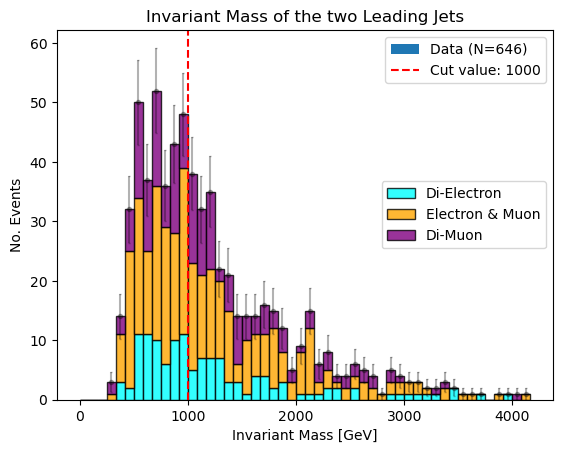

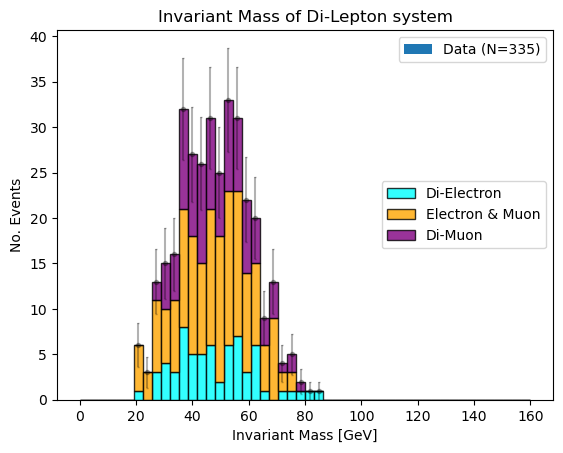

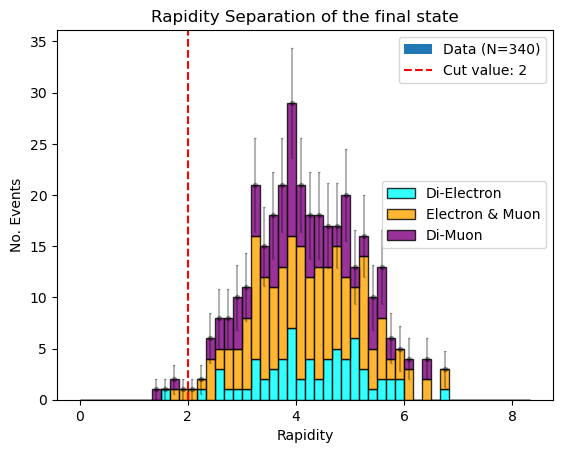

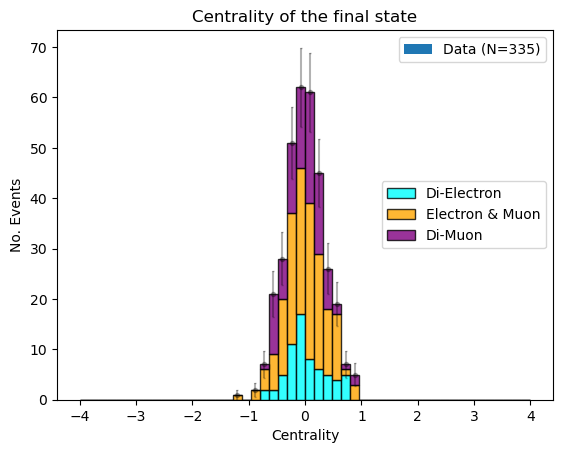

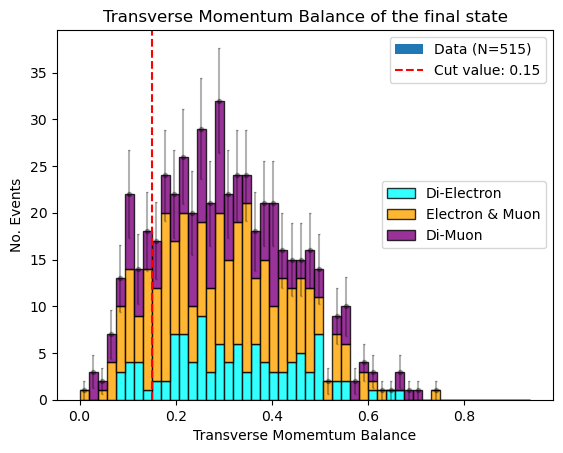

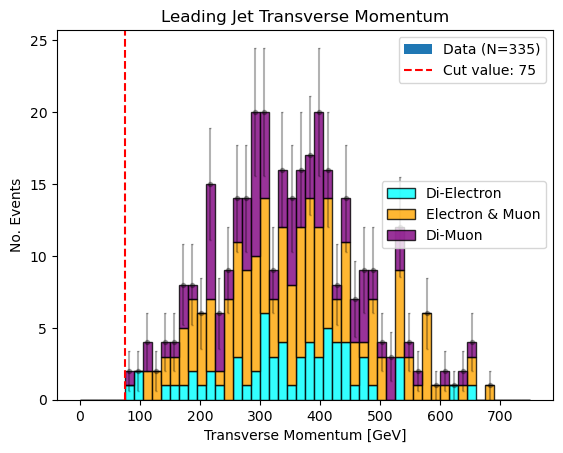

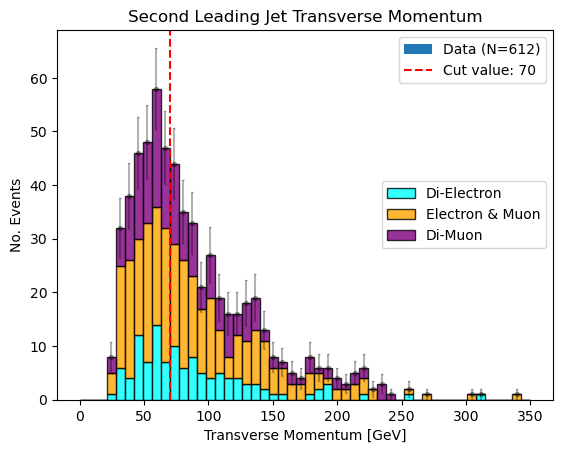

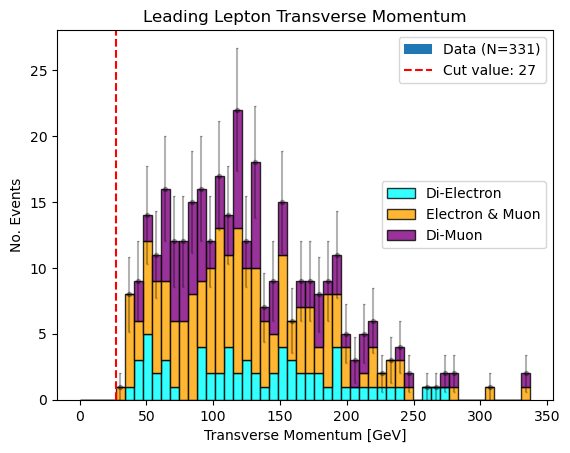

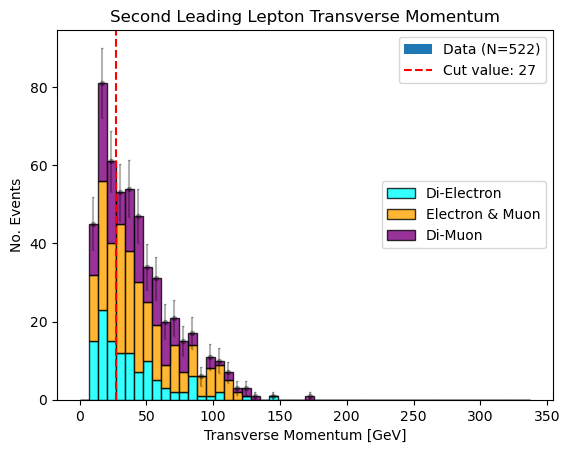

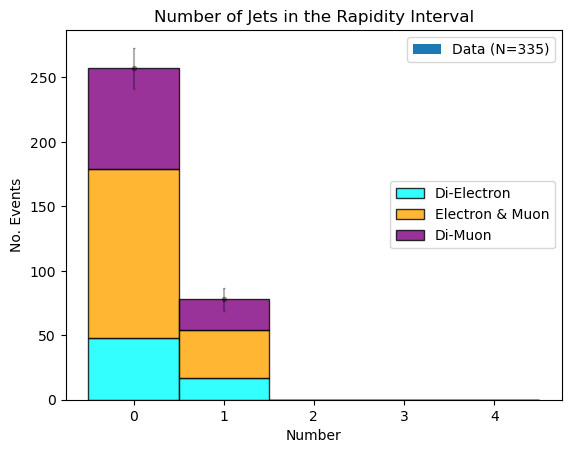

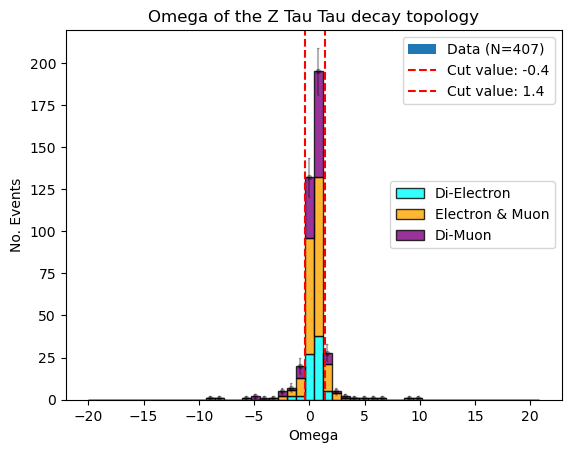

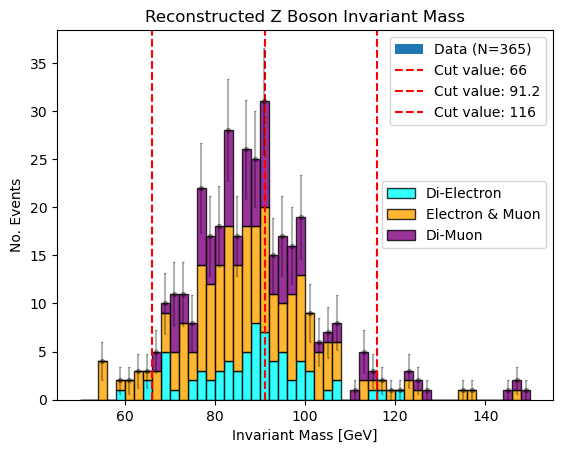

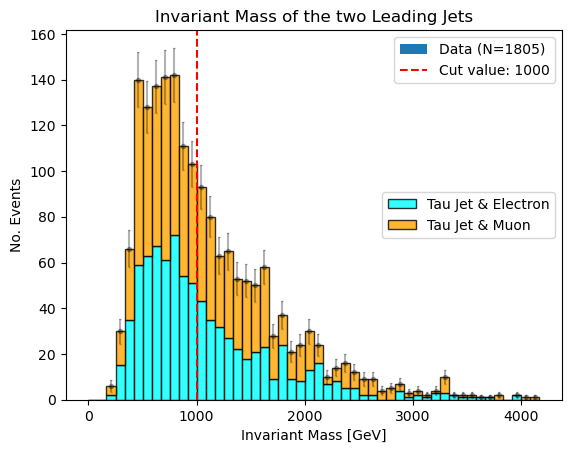

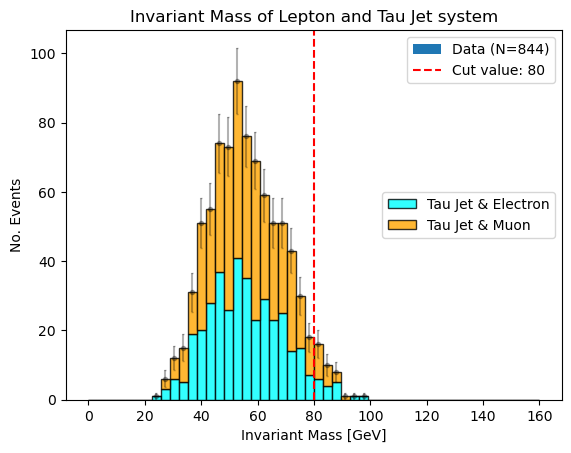

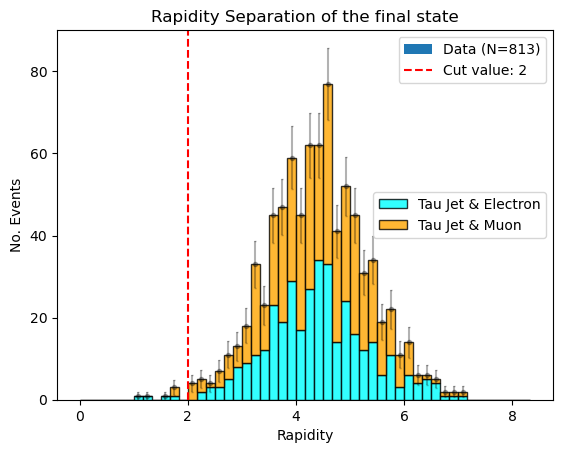

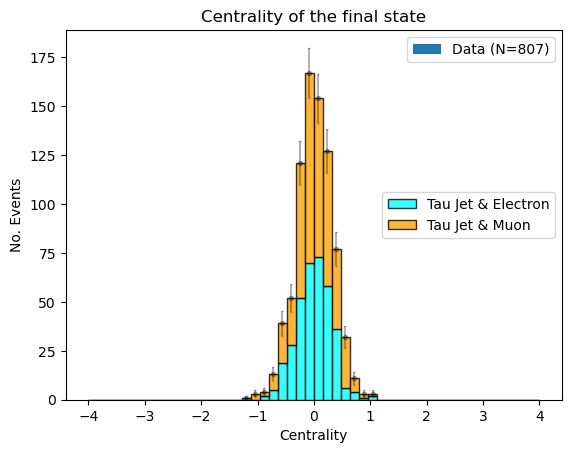

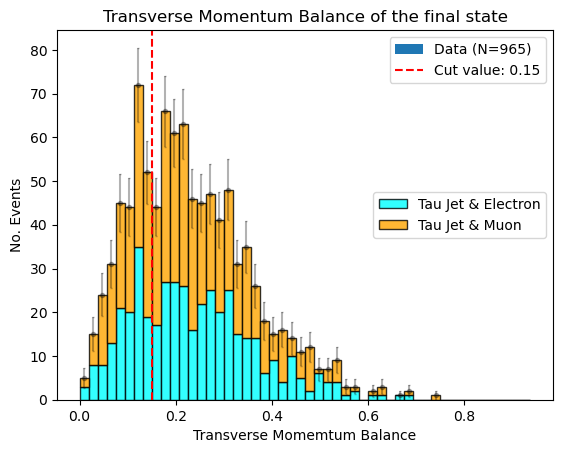

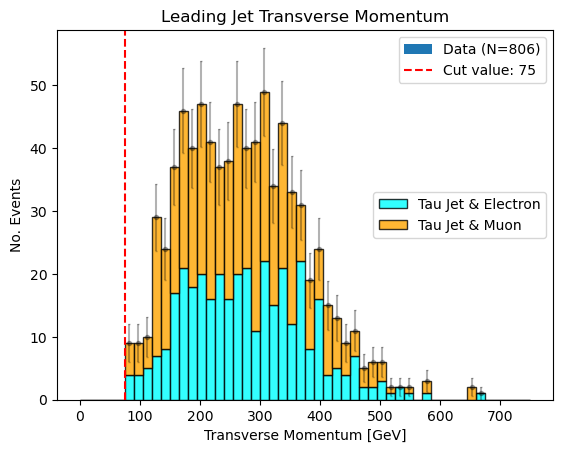

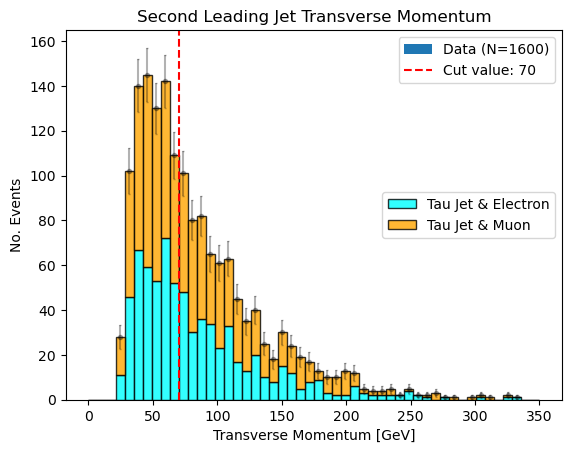

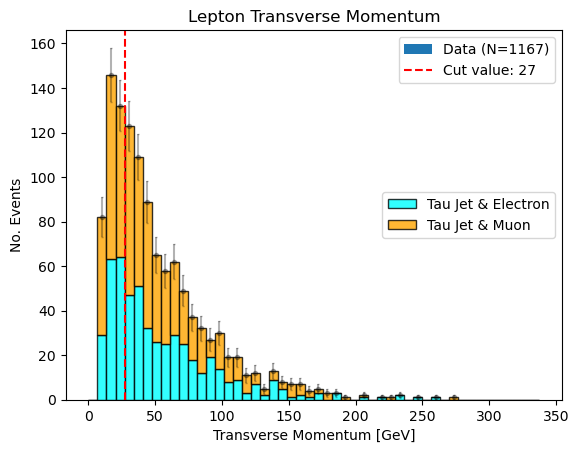

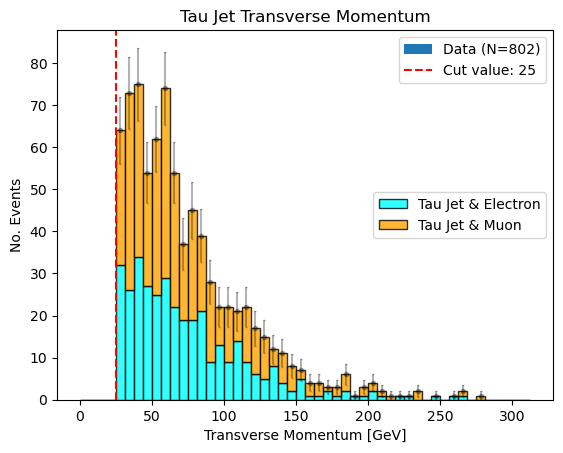

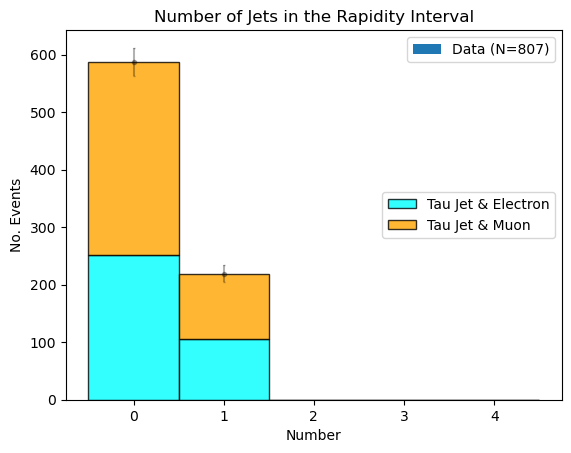

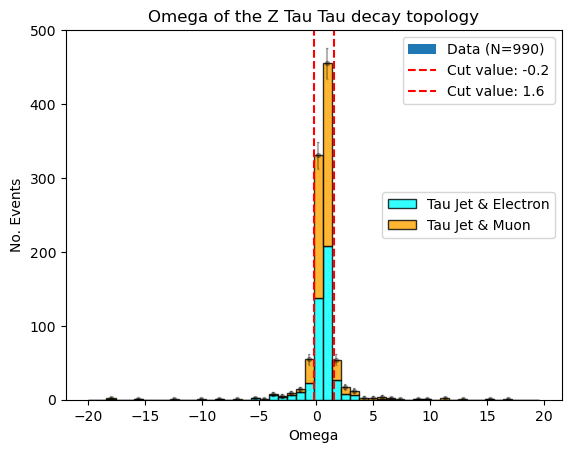

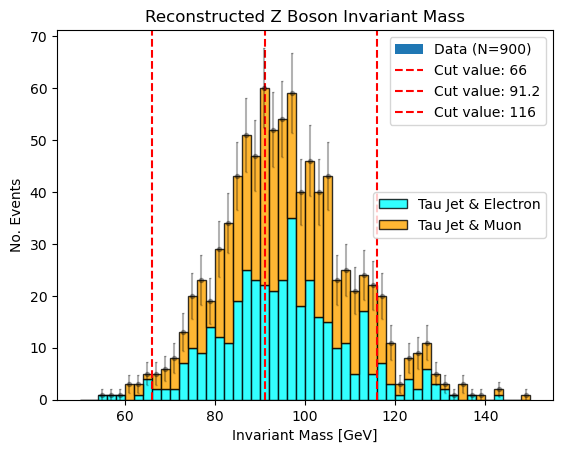

In [101]:
def main():
    all_operations(lepton_and_lepton, lep_channel_array, colours_array_lep_lep, labels_array_lep_lep, title_array_lep_lep, cut_values_lep_lep, line_values_lep_lep, line_bool_lep_lep, image_array_lep_lep, file_lep_lep)
    all_operations(jet_and_lepton, had_channel_array, colours_array_had_lep, labels_array_had_lep, title_array, cut_values, line_values, line_bool, image_array, file_)
    return

main()
